Esse notebook é responsável por analisar os dados do arquivo __data/dados_agregados__, fazer as limpezas necessárias nos dados e treinar o modelo para predizer os scores dos jogadores na próxima rodada do Cartola.

# Sumário

[1. Limpeza dos dados](#1.-Limpeza-dos-dados)
- [1.1 Carregamento dos dados](#1.1-Carregamento-dos-dados)
- [1.2 Limpeza básica](#1.2-Limpeza-básica)
- [1.3 Atualização dos times para os jogadores](#1.3-Atualização-dos-times-para-os-jogadores)
- [1.4 Atualização dos scouts cumulativos de 2015](#1.4-Atualização-dos-scouts-cumulativos-de-2015)
- [1.5 Verificação da pontuação com os scouts](#1.5-Verificação-da-pontuação-com-os-scouts)
- [1.6 Remoção das linhas duplicadas](#1.6-Remoção-das-linhas-duplicadas)

[2. Criação das amostras](#2.-Criação-das-amostras)

[3. Treinamento do Modelo](#3.-Treinamento-do-Modelo)

[4. Predições](#4.-Predições)

# 0. Dependências e configurações

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import _pickle as pkl
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

pd.set_option('display.max_columns', 100)

In [2]:
cols_scouts_def = ['CA','CV','DD','DP','FC','GC','GS','RB','SG'] # alphabetical order
cols_scouts_atk = ['A','FD','FF','FS','FT','G','I','PE','PP'] # alphabetical order
cols_scouts = cols_scouts_def + cols_scouts_atk

scouts_weights = np.array([-2.0, -5.0, 3.0, 7.0, -0.5, -6.0, -2.0, 1.7, 5.0, 5.0, 1.0, 0.7, 0.5, 3.5, 8.0, -0.5, -0.3, -3.5])

ROUND_TO_PREDICT = 38

# 1. Limpeza dos dados

A primeira seção desse notebook será responsável por analisar os dados do cartola e fazer as limpezas necessárias para criar amostras corretas e relevantes para o preditor. Analisando os dados previamente, alguns problemas foram detectados:

- __Jogadores com todos os scouts NANs__.
- __Jogadores com a coluna 'ClubeID' = NAN__.
- __Jogadores com a coluna 'Status' = NAN__.
- __Jogadores com a pontuação não equivalente a soma ponderada dos scouts__.
- __A coluna 'atletas.clube_id' tem campos repetidos e divergentes__: por exemplo, todos os Atléticos (MG, PR, e GO) são ATL. Além disso, há jogadores com siglas diferentes das equipes que eles jogam (por exemplo, Maicosuel [id: 37851]).
- __A coluna 'athletes.atletas.scout' não é informativa__.
- __Os scouts de 2015 dos jogadores são cumulativos__: ou seja, os scouts dos jogadores vão sendo somados a cada rodada. Entretanto, a pontuação não é. Isso também causa o repetimento de dados.

> __Importante__: na limpeza dos dados, para manter a consistência dos dados, __nenhuma coluna será adicionada, alterada ou removida__. Entretanto, os dados podem ser removidos ou corrigidos quando necessário.

### 1.1 Carregamento dos dados

In [3]:
df = pd.read_csv('../../data/dados_agregados.csv')
print(df.shape)
df.head(10)

(43821, 77)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS,ano,Apelido,Status,avg.Points,avg.last05,avg.FS,avg.FS.l05,avg.PE,avg.PE.l05,avg.A,avg.A.l05,avg.FT,avg.FT.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.G,avg.G.l05,avg.I,avg.I.l05,avg.PP,avg.PP.l05,avg.RB,avg.RB.l05,avg.FC,avg.FC.l05,avg.GC,avg.GC.l05,avg.CA,avg.CV.l05,avg.SG,avg.SG.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.GS,avg.GS.l05,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
0,36443,1,285.0,True,gol,1.0,5.0,5.00,10.60,1.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2014,NaN,NaN,2.500000,1.00,0.000000,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.500000,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,1.000000,4.0,19.0,1.0,0.0,NaN,NaN,NaN,NaN,home.team
1,36443,2,285.0,True,gol,2.0,-3.0,1.00,8.27,-2.33,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2014,NaN,NaN,0.666667,1.00,0.666667,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.333333,1.0,0.000000,1.0,0.0,1.0,0.666667,1.0,1.000000,4.0,27.0,2.0,2.0,NaN,NaN,NaN,NaN,away.team
2,36443,3,285.0,True,gol,3.0,-2.6,-0.20,6.81,-1.46,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2014,NaN,NaN,-0.150000,1.00,0.500000,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.250000,1.0,0.000000,1.0,0.0,1.0,0.750000,1.0,1.000000,5.0,4.0,2.0,1.0,NaN,NaN,NaN,NaN,home.team
3,36443,4,285.0,True,gol,4.0,4.0,0.85,7.96,1.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,2014,NaN,NaN,0.680000,0.68,0.400000,0.4,0.400000,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.200000,0.2,0.400000,0.4,0.0,0.0,0.800000,0.8,1.000000,5.0,10.0,2.0,1.0,NaN,NaN,NaN,NaN,home.team
4,36443,5,285.0,True,gol,5.0,5.0,1.68,8.61,0.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2014,NaN,NaN,1.400000,1.68,0.333333,0.4,0.333333,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.333333,0.4,0.333333,0.4,0.0,0.0,0.666667,0.8,1.000000,5.0,18.0,0.0,0.0,NaN,NaN,NaN,NaN,away.team
5,36443,6,285.0,True,gol,6.0,1.2,1.60,8.02,-0.59,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,2,0,1,2014,NaN,NaN,1.371429,0.92,0.285714,0.4,0.428571,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.2,0.0,0.0,0.142857,0.0,0.285714,0.2,0.571429,0.8,0.0,0.0,0.714286,1.0,1.000000,5.0,21.0,1.0,1.0,NaN,NaN,NaN,NaN,away.team
6,36443,7,285.0,True,gol,7.0,-3.3,0.90,6.75,-1.27,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,2014,NaN,NaN,0.787500,0.86,0.250000,0.0,0.500000,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.2,0.0,0.0,0.125000,0.0,0.250000,0.2,0.625000,1.0,0.0,0.0,1.000000,1.2,1.000000,5.0,25.0,1.0,3.0,NaN,NaN,NaN,NaN,home.team
7,36443,8,285.0,True,gol,8.0,3.0,1.16,7.55,0.80,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2014,NaN,NaN,1.033333,1.98,0.222222,0.0,0.444444,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.2,0.0,0.0,0.222222,0.0,0.333333,0.4,0.555556,1.0,0.0,0.0,0.888889,1.0,1.000000,5.0,28.0,2.0,0.0,NaN,NaN,NaN,NaN,home.team
8,36443,9,285.0,True,gol,9.0,-1.5,0.86,6.71,-0.84,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2014,NaN,NaN,0.780000,0.88,0.300000,0.2,0.400000,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.2,0.0,0.0,0.200000,0.0,0.300000,0.4,0.500000,0.6,0.0,0.0,0.900000,1.0,3.320910,6.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,away.team
9,36443,10,285.0,True,gol,10.0,-4.0,0.37,6.01,-0.70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2014,NaN,NaN,0.345455,-0.92,0.272727,0.2,0.363636,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.2,0.0,0.0,0.181818,0.0,0.272727,0.2,0.454545,0.6,0.0,0.0,1.000000,1.4,3.649901,7.0,17.0,2.0,1.0,NaN,NaN,NaN,NaN,away.team


### 1.2 Limpeza básica

In [4]:
print("Dimensões originais dos dados: ", df.shape)

# remove todas as linhas cujo scouts são NANs 
df_clean = df.dropna(how='all', subset=cols_scouts)
print('qtde. de jogadores com scouts: ', df_clean.shape[0])

# remove todas as linhas com rodada == 0
df_clean = df_clean[df_clean['Rodada'] > 0]
print("qtde. de linhas após eliminação da rodada 0: ", df_clean.shape[0])

# remove técnicos e jogadores sem posição
df_clean = df_clean[(df_clean['Posicao'] != "tec") & (~df_clean['Posicao'].isnull())]
print("qtde. de linhas com posições válidas: ", df_clean.shape[0])

# remove todos os jogadores que não participaram de alguma rodada
df_clean = df_clean[(df_clean['Participou'] == True) | (df_clean['PrecoVariacao'] != 0)]
print("qtde. de linhas com jogadores que participaram de alguma rodada: ", df_clean.shape[0])

# altera os Status = NAN para 'Provável'
df_clean.loc[df_clean.Status.isnull(), 'Status'] = 'Provável'

# atualiza nomes dos jogadores sem ids e remove jogadores sem nome
df_ids =  df.groupby('AtletaID')['Apelido'].unique()
dict_ids = dict(zip(df_ids.index, [str(v[-1]) for v in df_ids.values]))
dict_ids = {k:v for k,v in dict_ids.items() if v != 'nan'}
df_clean['Apelido'] = df_clean['AtletaID'].map(dict_ids)
df_clean = df_clean[~df_clean['Apelido'].isnull()]
print("qtde. de jogadores com nome: ", df_clean.shape[0])

# preenche NANs restantes com zeros (verificado antes!)
df_clean.fillna(value=0, inplace=True)

print("Dimensão dos dados após as limpezas: ", df_clean.shape)
df_clean.head(10)

Dimensões originais dos dados:  (43821, 77)
qtde. de jogadores com scouts:  43821
qtde. de linhas após eliminação da rodada 0:  43821
qtde. de linhas com posições válidas:  33045
qtde. de linhas com jogadores que participaram de alguma rodada:  33045
qtde. de jogadores com nome:  22839
Dimensão dos dados após as limpezas:  (22839, 77)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS,ano,Apelido,Status,avg.Points,avg.last05,avg.FS,avg.FS.l05,avg.PE,avg.PE.l05,avg.A,avg.A.l05,avg.FT,avg.FT.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.G,avg.G.l05,avg.I,avg.I.l05,avg.PP,avg.PP.l05,avg.RB,avg.RB.l05,avg.FC,avg.FC.l05,avg.GC,avg.GC.l05,avg.CA,avg.CV.l05,avg.SG,avg.SG.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.GS,avg.GS.l05,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
53,36540,1,285.0,True,zag,1.0,2.0,2.00,12.88,-2.12,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,2014,Juan,Provável,1.000000,1.00,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.000000,1.0,0.0,1.0,0.500000,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.000000,4.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,home.team
54,36540,2,285.0,True,zag,2.0,3.4,2.70,12.04,-0.84,1,4,0,0,1,1,0,0,0,2,2,0,0,0,0,0,0,0,2014,Juan,Provável,1.800000,1.00,0.333333,1.0,1.333333,1.0,0.000000,1.0,0.0,1.0,0.333333,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.666667,1.0,1.333333,1.0,0.0,1.0,0.333333,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.000000,4.0,27.0,2.0,2.0,0.0,0.0,0.0,0.0,away.team
55,36540,3,285.0,True,zag,3.0,0.1,1.83,10.85,-1.19,4,2,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,2014,Juan,Provável,1.375000,1.00,1.250000,1.0,1.500000,1.0,0.000000,1.0,0.0,1.0,0.250000,1.0,0.250000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.750000,1.0,1.500000,1.0,0.0,1.0,0.500000,1.0,0.250000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.000000,5.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
56,36540,4,285.0,True,zag,4.0,0.9,1.60,10.61,-0.24,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2014,Juan,Provável,1.280000,1.28,1.200000,1.2,1.600000,1.6,0.000000,0.0,0.0,0.0,0.400000,0.4,0.200000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.6,1.200000,1.2,0.0,0.0,0.400000,0.0,0.200000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,10.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
57,36540,5,285.0,True,zag,5.0,1.2,1.52,10.45,-0.16,0,0,0,0,0,1,0,0,0,0,5,0,1,0,1,0,0,0,2014,Juan,Provável,1.266667,1.52,1.000000,1.2,1.333333,1.6,0.000000,0.0,0.0,0.0,0.333333,0.4,0.333333,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.6,1.833333,2.2,0.0,0.0,0.500000,0.0,0.333333,0.4,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,away.team
58,36540,7,285.0,True,zag,6.0,1.9,1.58,10.14,-0.31,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2014,Juan,Provável,1.187500,0.82,0.875000,1.2,1.000000,0.8,0.000000,0.0,0.0,0.0,0.250000,0.2,0.500000,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.375000,0.2,1.375000,1.4,0.0,0.0,0.375000,0.0,0.250000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,25.0,1.0,3.0,0.0,0.0,0.0,0.0,home.team
59,36540,8,285.0,True,zag,7.0,10.7,2.88,11.87,1.73,2,2,0,0,0,1,0,0,0,3,1,0,0,0,1,0,0,0,2014,Juan,Provável,2.244444,2.94,1.000000,0.8,1.111111,0.8,0.000000,0.0,0.0,0.0,0.222222,0.2,0.555556,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.6,1.333333,1.2,0.0,0.0,0.333333,0.0,0.333333,0.4,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,28.0,2.0,0.0,0.0,0.0,0.0,0.0,home.team
60,36540,9,285.0,True,zag,8.0,4.1,3.03,11.20,-0.67,1,1,0,0,1,0,0,0,0,2,1,0,0,0,0,0,0,0,2014,Juan,Provável,2.430000,3.58,1.000000,0.8,1.100000,0.6,0.000000,0.0,0.0,0.0,0.300000,0.2,0.500000,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,1.0,1.300000,1.4,0.0,0.0,0.300000,0.0,0.300000,0.4,0.0,0.0,0.0,0.0,0.0,0.0,3.226298,6.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,away.team
61,36540,10,285.0,True,zag,9.0,0.4,2.74,10.70,-0.50,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2014,Juan,Provável,2.245455,3.42,0.909091,0.8,1.090909,0.8,0.000000,0.0,0.0,0.0,0.272727,0.2,0.545455,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,1.0,1.181818,0.4,0.0,0.0,0.272727,0.0,0.272727,0.2,0.0,0.0,0.0,0.0,0.0,0.0,3.195153,7.0,17.0,2.0,1.0,0.0,0.0,0.0,0.0,away.team
62,36540,11,285.0,True,zag,10.0,10.0,3.47,12.69,1.99,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2014,Juan,Provável,2.891667,5.42,0.833333,0.8,1.000000,0.8,0.083333,0.2,0.0,0.0,0.250000,0.2,0.500000,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,1.0,

### 1.3 Atualização dos times para os jogadores

In [5]:
df_teams = pd.read_csv('../../data/times_ids.csv')
df_teams = df_teams.dropna()
print(df_teams.shape)
df_teams.head()

(43, 6)


,nome.cbf,nome.cartola,nome.completo,cod.older,cod.2017,id
0,América - MG,América-MG,America MG,327,327,327
1,America - RN,Atlético-RN,America RN,200,200,200
2,Atlético - GO,Atlético-GO,Atletico GO,201,373,373
3,Atlético - MG,Atlético-MG,Atletico Mineiro,282,282,282
4,Atlético - PR,Atlético-PR,Atletico Paranaense,293,293,293


In [6]:
# do not run this cell twice!
dict_teams_id = dict(zip(df_teams['id'], df_teams['nome.cartola']))
dict_teams_id.update(dict(zip(df_teams['cod.older'], df_teams['nome.cartola'])))

df_clean['ClubeID'] = df_clean['ClubeID'].astype(np.int).map(dict_teams_id)
df_clean = df_clean.dropna()

print(df_clean.shape)
df_clean.head()

(22469, 77)


,AtletaID,Rodada,ClubeID,Participou,Posicao,Jogos,Pontos,PontosMedia,Preco,PrecoVariacao,FS,PE,A,FT,FD,FF,G,I,PP,RB,FC,GC,CA,CV,SG,DD,DP,GS,ano,Apelido,Status,avg.Points,avg.last05,avg.FS,avg.FS.l05,avg.PE,avg.PE.l05,avg.A,avg.A.l05,avg.FT,avg.FT.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.G,avg.G.l05,avg.I,avg.I.l05,avg.PP,avg.PP.l05,avg.RB,avg.RB.l05,avg.FC,avg.FC.l05,avg.GC,avg.GC.l05,avg.CA,avg.CV.l05,avg.SG,avg.SG.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.GS,avg.GS.l05,risk_points,mes,dia,home.score.x,away.score.x,pred.home.score,pred.away.score,home.attack,home.defend,variable
53,36540,1,Internacional,True,zag,1.0,2.0,2.00,12.88,-2.12,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,2014,Juan,Provável,1.000000,1.00,0.000000,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,1.000000,1.0,0.0,1.0,0.500000,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,home.team
54,36540,2,Internacional,True,zag,2.0,3.4,2.70,12.04,-0.84,1,4,0,0,1,1,0,0,0,2,2,0,0,0,0,0,0,0,2014,Juan,Provável,1.800000,1.00,0.333333,1.0,1.333333,1.0,0.0,1.0,0.0,1.0,0.333333,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.666667,1.0,1.333333,1.0,0.0,1.0,0.333333,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,4.0,27.0,2.0,2.0,0.0,0.0,0.0,0.0,away.team
55,36540,3,Internacional,True,zag,3.0,0.1,1.83,10.85,-1.19,4,2,0,0,0,0,0,0,0,1,2,0,1,0,0,0,0,0,2014,Juan,Provável,1.375000,1.00,1.250000,1.0,1.500000,1.0,0.0,1.0,0.0,1.0,0.250000,1.0,0.250000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.750000,1.0,1.500000,1.0,0.0,1.0,0.500000,1.0,0.250000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,5.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
56,36540,4,Internacional,True,zag,4.0,0.9,1.60,10.61,-0.24,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2014,Juan,Provável,1.280000,1.28,1.200000,1.2,1.600000,1.6,0.0,0.0,0.0,0.0,0.400000,0.4,0.200000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.6,1.200000,1.2,0.0,0.0,0.400000,0.0,0.200000,0.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,10.0,2.0,1.0,0.0,0.0,0.0,0.0,home.team
57,36540,5,Internacional,True,zag,5.0,1.2,1.52,10.45,-0.16,0,0,0,0,0,1,0,0,0,0,5,0,1,0,1,0,0,0,2014,Juan,Provável,1.266667,1.52,1.000000,1.2,1.333333,1.6,0.0,0.0,0.0,0.0,0.333333,0.4,0.333333,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.6,1.833333,2.2,0.0,0.0,0.500000,0.0,0.333333,0.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,away.team


### 1.4 Atualização dos scouts cumulativos de 2015

Como dito anteriomente, os dados sobre os scouts de 2015 são cumulativos, ou seja, os scouts de uma rodada são adicionados aos scouts anteriores a cada nova rodada que um jogador participa. Portanto, nessa seção vamos tirar essa acumulação para cada jogador. 

Para isso, dada uma rodada específica, os scouts de um jogador são subtraídos do máximo dos scouts de todas as rodadas anteriores. Repare que assim há chance do scout __Jogo Sem Sofrer Gols (SG)__ ser negativo se o jogador não sofre gols na rodada anterior e sofre na rodada atual. Quando isso acontece, esse scout será atualizado.

In [7]:
def get_scouts_for_round(df, round_):
    suffixes = ('_curr', '_prev')
    cols_current = [col + suffixes[0] for col in cols_scouts]
    cols_prev = [col + suffixes[1] for col in cols_scouts]
    
    df_round = df[df['Rodada'] == round_]
    if round_ == 1: return df_round
    
    df_round_prev = df[df['Rodada'] < round_].groupby('AtletaID', as_index=False)[cols_scouts].max()
    df_players = df_round.merge(df_round_prev, how='left', on=['AtletaID'], suffixes=suffixes)
    
    # if is the first round of a player, the scouts of previous rounds will be NaNs. Thus, set them to zero
    df_players.fillna(value=0, inplace=True)
    
    # compute the scouts 
    df_players[cols_current] = df_players[cols_current].values - df_players[cols_prev].values
    
    # update the columns
    df_players.drop(labels=cols_prev, axis=1, inplace=True)
    df_players = df_players.rename(columns=dict(zip(cols_current, cols_scouts)))
    df_players.SG = df_players.SG.clip_lower(0)
    
    return df_players

A célula abaixo cria uma dataframe com os scouts dos jogadores não acumulados.

In [8]:
df_scouts = df_clean[df_clean['ano'] != 2015]
df_scouts_2015 = df_clean[df_clean['ano'] == 2015]

n_rounds = df_scouts_2015['Rodada'].max()

if np.isnan(n_rounds):
    df_scouts = df_clean
else:
    for i in range(1, n_rounds+1):
        df_round = get_scouts_for_round(df_scouts_2015, i)
        print("Dimensões da rodada #{0}: {1}".format(i, df_round.shape))
        df_scouts = df_scouts.append(df_round, ignore_index=True)
    
print(df_scouts.shape)
df_scouts.head()

Dimensões da rodada #1: (104, 77)
Dimensões da rodada #2: (111, 77)
Dimensões da rodada #3: (108, 77)
Dimensões da rodada #4: (110, 77)
Dimensões da rodada #5: (110, 77)
Dimensões da rodada #6: (105, 77)
Dimensões da rodada #7: (87, 77)
Dimensões da rodada #8: (98, 77)
Dimensões da rodada #9: (94, 77)
Dimensões da rodada #10: (104, 77)
Dimensões da rodada #11: (100, 77)
Dimensões da rodada #12: (99, 77)
Dimensões da rodada #13: (98, 77)
Dimensões da rodada #14: (100, 77)
Dimensões da rodada #15: (98, 77)
Dimensões da rodada #16: (85, 77)
Dimensões da rodada #17: (109, 77)
Dimensões da rodada #18: (107, 77)
Dimensões da rodada #19: (105, 77)
Dimensões da rodada #20: (112, 77)
Dimensões da rodada #21: (104, 77)
Dimensões da rodada #22: (99, 77)
Dimensões da rodada #23: (99, 77)
Dimensões da rodada #24: (94, 77)
Dimensões da rodada #25: (105, 77)
Dimensões da rodada #26: (0, 77)
Dimensões da rodada #27: (109, 77)
Dimensões da rodada #28: (100, 77)
Dimensões da rodada #29: (109, 77)
Dimens

,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Participou,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,Status,ano,avg.A,avg.A.l05,avg.CA,avg.CV.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.FC,avg.FC.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.FS,avg.FS.l05,avg.FT,avg.FT.l05,avg.G,avg.G.l05,avg.GC,avg.GC.l05,avg.GS,avg.GS.l05,avg.I,avg.I.l05,avg.PE,avg.PE.l05,avg.PP,avg.PP.l05,avg.Points,avg.RB,avg.RB.l05,avg.SG,avg.SG.l05,avg.last05,away.score.x,dia,home.attack,home.defend,home.score.x,mes,pred.away.score,pred.home.score,risk_points,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,2.0,2.00,zag,12.88,-2.12,0.0,1,1.0,Provável,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1.0,1.000000,0.000000,1.0,0.500000,1.0,1.00,0.0,19.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,home.team
1,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,True,3.4,2.70,zag,12.04,-0.84,2.0,2,0.0,Provável,2014,0.0,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.333333,1.0,0.333333,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.0,1.0,1.800000,0.666667,1.0,0.333333,1.0,1.00,2.0,27.0,0.0,0.0,2.0,4.0,0.0,0.0,1.0,away.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,True,0.1,1.83,zag,10.85,-1.19,1.0,3,0.0,Provável,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.250000,1.0,0.250000,1.0,1.250000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.0,1.0,1.375000,0.750000,1.0,0.250000,1.0,1.00,1.0,4.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
3,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,True,0.9,1.60,zag,10.61,-0.24,0.0,4,0.0,Provável,2014,0.0,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,1.200000,1.2,0.400000,0.4,0.200000,0.2,1.200000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.600000,1.6,0.0,0.0,1.280000,0.600000,0.6,0.200000,0.2,1.28,1.0,10.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,True,1.2,1.52,zag,10.45,-0.16,0.0,5,1.0,Provável,2014,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,1.833333,2.2,0.333333,0.4,0.333333,0.4,1.000000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,1.6,0.0,0.0,1.266667,0.500000,0.6,0.333333,0.4,1.52,0.0,18.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,away.team


### 1.5 Verificação da pontuação com os scouts

Vamos agora verificar se a coluna com a pontuação do jogador condiz com seus scouts:

In [9]:
def check_scouts(row):
    return np.sum(scouts_weights*row[cols_scouts])

players_points = df_scouts.apply(check_scouts, axis=1)
errors = np.where(~np.isclose(df_scouts['Pontos'].values, players_points))[0]
print("qtde. de jogadores com pontuação diferente dos scouts: ", errors.shape)
df_scouts.iloc[errors, :].tail(10)

qtde. de jogadores com pontuação diferente dos scouts:  (4244,)


,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Participou,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,Status,ano,avg.A,avg.A.l05,avg.CA,avg.CV.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.FC,avg.FC.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.FS,avg.FS.l05,avg.FT,avg.FT.l05,avg.G,avg.G.l05,avg.GC,avg.GC.l05,avg.GS,avg.GS.l05,avg.I,avg.I.l05,avg.PE,avg.PE.l05,avg.PP,avg.PP.l05,avg.Points,avg.RB,avg.RB.l05,avg.SG,avg.SG.l05,avg.last05,away.score.x,dia,home.attack,home.defend,home.score.x,mes,pred.away.score,pred.home.score,risk_points,variable
22459,-1.0,Everton,86757,0.0,0.0,Grêmio,0.0,0.0,-2.0,-2.0,0.0,-2.0,-1.0,0.0,0.0,0.0,-1.0,14.0,-1.0,0.0,True,-0.3,4.56,ata,5.52,-1.74,-1.0,37,0.0,Provável,2015,0.013158,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.052632,0.8,0.144737,0.6,0.131579,0.4,0.052632,0.0,0.026316,0.4,0.052632,0.4,0.0,0.0,0.0,0.0,0.026316,0.4,0.223684,1.4,0.0,0.0,0.826316,0.131579,0.6,0.000000,0.0,3.46,1.0,29.0,0.0,0.0,2.0,11.0,0.0,0.0,4.471092,home.team
22460,-2.0,Luan,86759,-1.0,0.0,Grêmio,0.0,0.0,-3.0,-5.0,-3.0,-6.0,-1.0,-2.0,0.0,0.0,-2.0,33.0,-7.0,0.0,True,0.5,5.78,ata,26.98,-1.32,-3.0,37,0.0,Provável,2015,0.118421,0.2,0.118421,0.0,0.0,0.0,0.0,0.0,1.223684,2.4,0.526316,1.0,0.605263,0.8,1.921053,3.2,0.039474,0.0,0.184211,0.4,0.0,0.0,0.0,0.0,0.355263,0.4,2.184211,2.8,0.0,0.0,3.176316,0.618421,0.2,0.000000,0.0,3.22,1.0,29.0,0.0,0.0,2.0,11.0,0.0,0.0,4.392683,home.team
22461,0.0,Sidcley,86764,-1.0,0.0,Atlético-PR,0.0,0.0,-3.0,-1.0,-1.0,-2.0,-1.0,-1.0,0.0,0.0,-1.0,24.0,-3.0,0.0,True,8.8,4.00,lat,8.63,0.86,-2.0,37,0.0,Provável,2015,0.030303,0.4,0.075758,0.0,0.0,0.0,0.0,0.0,0.469697,1.2,0.045455,0.2,0.166667,0.4,0.439394,1.0,0.015152,0.2,0.030303,0.2,0.0,0.0,0.0,0.0,0.015152,0.2,1.287879,2.8,0.0,0.0,1.659091,0.484848,1.6,0.166667,0.6,8.56,0.0,29.0,0.0,0.0,3.0,11.0,0.0,0.0,5.100762,home.team
22462,-1.0,Zeca,87192,-1.0,0.0,Santos,0.0,0.0,2.0,-1.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,22.0,-7.0,0.0,True,-1.5,4.91,lat,5.62,-1.40,-6.0,37,0.0,Provável,2015,0.065789,0.2,0.039474,0.0,0.0,0.0,0.0,0.0,0.447368,1.2,0.026316,0.0,0.039474,0.4,0.381579,0.2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.289474,0.4,0.0,0.0,2.002632,0.697368,0.6,0.210526,0.2,2.28,0.0,29.0,0.0,0.0,1.0,11.0,0.0,0.0,3.526156,away.team
22463,0.0,Neto Moura,87742,-1.0,0.0,Sport,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,21.0,-2.0,0.0,True,1.8,0.91,mei,3.28,0.22,-2.0,37,0.0,Provável,2015,0.000000,0.0,0.039474,0.0,0.0,0.0,0.0,0.0,0.157895,0.4,0.026316,0.0,0.092105,0.4,0.131579,0.8,0.000000,0.0,0.013158,0.0,0.0,0.0,0.0,0.0,0.013158,0.0,0.421053,0.4,0.0,0.0,0.255263,0.171053,0.4,0.000000,0.0,0.94,0.0,29.0,0.0,0.0,2.0,11.0,0.0,0.0,1.400833,home.team
22464,-2.0,Yago,87747,-1.0,0.0,Figueirense,0.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,0.0,0.0,0.0,27.0,1.0,0.0,True,3.1,1.60,mei,3.86,0.81,0.0,37,0.0,Provável,2015,0.052632,0.0,0.092105,0.0,0.0,0.0,0.0,0.0,0.526316,1.8,0.065789,0.0,0.052632,0.0,0.434211,1.4,0.000000,0.0,0.013158,0.2,0.0,0.0,0.0,0.0,0.000000,0.0,0.947368,3.2,0.0,0.0,0.668421,0.394737,1.6,0.000000,0.0,3.10,2.0,28.0,0.0,0.0,3.0,11.0,0.0,0.0,3.849444,away.team
22465,-1.0,Gustavo Scarpa,87999,-1.0,0.0,Fluminense,0.0,0.0,1.0,-2.0,-3.0,-2.0,0.0,-1.0,0.0,0.0,-1.0,28.0,3.0,0.0,True,-1.1,3.01,mei,4.75,-0.06,-2.0,37,0.0,Provável,2015,0.026316,0.0,0.039474,0.0,0.0,0.0,0.0,0.0,0.500000,3.0,0.157895,0.4,0.184211,0.8,0.500000,2.4,0.000000,0.0,0.065789,0.2,0.0,0.0,0.0,0.0,0.026316,0.0,1.605263,4.8,0.0,0.0,1.123684,0.434211,1.2,0.000000,0.0,3.08,1.0,28.0,0.0,0.0,1.0,11.0,0.0,0.0,4.134959,home.team
22466,0.0,Serginho,88002,0.0,0.0,Santos,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,10.0,-1.0,0.0,True,-1.8,-0.06,mei,1.23,-0.17,-1.0,37,0.0,Provável,2015,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.157895,1.4,0.013158,0.0,0.013158,0.0,0.052632,0.4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.039474,0.2,0.171053,0.8,0.0,0.0,0.010526,0.065789,0.0,0.000000,0.0,-0.84,0.0,29.0,0.0,0.0,1.0,11.0,0.0,0.0,0.597774,away.team
22467,0.0,Ángel Romero,8

Podemos ver que mais de 4000 jogadores têm sua pontuação não equivalente aos scouts. Portanto, como discutido na [issue #7](https://github.com/henriquepgomide/caRtola/issues/7), vamos apagar esses dados:

In [10]:
# remove such players with wrong pontuation (DO NOT RUN TWICE!)
df_scouts.reset_index(drop=True, inplace=True)
df_scouts.drop(df.index[errors], inplace=True)
print(df_scouts.shape)
df_scouts.head()

(18225, 77)


,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Participou,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,Status,ano,avg.A,avg.A.l05,avg.CA,avg.CV.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.FC,avg.FC.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.FS,avg.FS.l05,avg.FT,avg.FT.l05,avg.G,avg.G.l05,avg.GC,avg.GC.l05,avg.GS,avg.GS.l05,avg.I,avg.I.l05,avg.PE,avg.PE.l05,avg.PP,avg.PP.l05,avg.Points,avg.RB,avg.RB.l05,avg.SG,avg.SG.l05,avg.last05,away.score.x,dia,home.attack,home.defend,home.score.x,mes,pred.away.score,pred.home.score,risk_points,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,2.0,2.00,zag,12.88,-2.12,0.0,1,1.0,Provável,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1.0,1.000000,0.000000,1.0,0.500000,1.0,1.00,0.0,19.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,home.team
1,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,True,3.4,2.70,zag,12.04,-0.84,2.0,2,0.0,Provável,2014,0.0,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.333333,1.0,0.333333,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.0,1.0,1.800000,0.666667,1.0,0.333333,1.0,1.00,2.0,27.0,0.0,0.0,2.0,4.0,0.0,0.0,1.0,away.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,True,0.1,1.83,zag,10.85,-1.19,1.0,3,0.0,Provável,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.250000,1.0,0.250000,1.0,1.250000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.0,1.0,1.375000,0.750000,1.0,0.250000,1.0,1.00,1.0,4.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
3,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,True,0.9,1.60,zag,10.61,-0.24,0.0,4,0.0,Provável,2014,0.0,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,1.200000,1.2,0.400000,0.4,0.200000,0.2,1.200000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.600000,1.6,0.0,0.0,1.280000,0.600000,0.6,0.200000,0.2,1.28,1.0,10.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,True,1.2,1.52,zag,10.45,-0.16,0.0,5,1.0,Provável,2014,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,1.833333,2.2,0.333333,0.4,0.333333,0.4,1.000000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,1.6,0.0,0.0,1.266667,0.500000,0.6,0.333333,0.4,1.52,0.0,18.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,away.team


### 1.6 Remoção das linhas duplicadas

Por fim, vamos apagar as linhas repetidas do dataframe. Isso acontece pois, a partir da primeira participação de um jogador no campeonato, ele aparece em todas as rodadas subsequentes, mesmo que não tenha jogado.

In [11]:
df_scouts.drop_duplicates(subset=['AtletaID', 'ano']+cols_scouts, keep='first', inplace=True)

In [12]:
print("Dimensões dos dados após toda a limpeza de dados: ", df_scouts.shape)
df_scouts.to_csv('../../data/dados_agregados_limpos.csv', index=False)

Dimensões dos dados após toda a limpeza de dados:  (17567, 77)


# 2. Criação das amostras

Agora, vamos pegar os dados que limpamos e transformá-los em dados utilizáveis para criação dos modelos. Para isso, vamos efetuar as seguintes operações:

* __Selecionar somente as colunas de interesse__: colunas como _atletas.nome_, _atletas.foto_, etc não são relevantes para criação do modelo. No entanto, colunas como o *AtletaID* e *atletas.apelido*, mesmo que não utilizadas para treinamento do modelo, são importante para avaliar o resultado e, portanto, também serão consideradas.
* __Converter todos os dados categóricos para numéricos__: as colunas *Posicao*, *ClubeID*, *opponent* e *casa* serão convertidas numéricos. O correto seria utilizar a estratégia conhecida como _one-hot encoding_, mas para simplificar ela não será utilizada.

In [13]:
df_samples = pd.read_csv('../../data/dados_agregados_limpos.csv')
print(df_samples.shape)
df_samples.head()

(17567, 77)


,A,Apelido,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Participou,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,Status,ano,avg.A,avg.A.l05,avg.CA,avg.CV.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.FC,avg.FC.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.FS,avg.FS.l05,avg.FT,avg.FT.l05,avg.G,avg.G.l05,avg.GC,avg.GC.l05,avg.GS,avg.GS.l05,avg.I,avg.I.l05,avg.PE,avg.PE.l05,avg.PP,avg.PP.l05,avg.Points,avg.RB,avg.RB.l05,avg.SG,avg.SG.l05,avg.last05,away.score.x,dia,home.attack,home.defend,home.score.x,mes,pred.away.score,pred.home.score,risk_points,variable
0,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,True,2.0,2.00,zag,12.88,-2.12,0.0,1,1.0,Provável,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1.0,1.000000,0.000000,1.0,0.500000,1.0,1.00,0.0,19.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,home.team
1,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,True,3.4,2.70,zag,12.04,-0.84,2.0,2,0.0,Provável,2014,0.0,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.333333,1.0,0.333333,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.0,1.0,1.800000,0.666667,1.0,0.333333,1.0,1.00,2.0,27.0,0.0,0.0,2.0,4.0,0.0,0.0,1.0,away.team
2,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,True,0.1,1.83,zag,10.85,-1.19,1.0,3,0.0,Provável,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.250000,1.0,0.250000,1.0,1.250000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.0,1.0,1.375000,0.750000,1.0,0.250000,1.0,1.00,1.0,4.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
3,0.0,Juan,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,True,0.9,1.60,zag,10.61,-0.24,0.0,4,0.0,Provável,2014,0.0,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,1.200000,1.2,0.400000,0.4,0.200000,0.2,1.200000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.600000,1.6,0.0,0.0,1.280000,0.600000,0.6,0.200000,0.2,1.28,1.0,10.0,0.0,0.0,2.0,5.0,0.0,0.0,1.0,home.team
4,0.0,Juan,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,True,1.2,1.52,zag,10.45,-0.16,0.0,5,1.0,Provável,2014,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,1.833333,2.2,0.333333,0.4,0.333333,0.4,1.000000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,1.6,0.0,0.0,1.266667,0.500000,0.6,0.333333,0.4,1.52,0.0,18.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,away.team


In [14]:
# seleciona somente as colunas de interesse para usar como atributos
cols_of_interest = df_samples.columns.difference(['Apelido', 'Status', 'Participou', 'dia', 'mes']).values.tolist()

# 'Rodada' e 'ano' serão usadas para criar amostras
cols_info = ['Rodada', 'ano']

df_samples = df_samples[cols_of_interest]
df_samples.head()

,A,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,ano,avg.A,avg.A.l05,avg.CA,avg.CV.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.FC,avg.FC.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.FS,avg.FS.l05,avg.FT,avg.FT.l05,avg.G,avg.G.l05,avg.GC,avg.GC.l05,avg.GS,avg.GS.l05,avg.I,avg.I.l05,avg.PE,avg.PE.l05,avg.PP,avg.PP.l05,avg.Points,avg.RB,avg.RB.l05,avg.SG,avg.SG.l05,avg.last05,away.score.x,home.attack,home.defend,home.score.x,pred.away.score,pred.home.score,risk_points,variable
0,0.0,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.00,zag,12.88,-2.12,0.0,1,1.0,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1.0,1.000000,0.000000,1.0,0.500000,1.0,1.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,home.team
1,0.0,36540,0.0,0.0,Internacional,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,3.4,2.70,zag,12.04,-0.84,2.0,2,0.0,2014,0.0,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.333333,1.0,0.333333,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.0,1.0,1.800000,0.666667,1.0,0.333333,1.0,1.00,2.0,0.0,0.0,2.0,0.0,0.0,1.0,away.team
2,0.0,36540,1.0,0.0,Internacional,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.1,1.83,zag,10.85,-1.19,1.0,3,0.0,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.250000,1.0,0.250000,1.0,1.250000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.0,1.0,1.375000,0.750000,1.0,0.250000,1.0,1.00,1.0,0.0,0.0,2.0,0.0,0.0,1.0,home.team
3,0.0,36540,0.0,0.0,Internacional,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.9,1.60,zag,10.61,-0.24,0.0,4,0.0,2014,0.0,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,1.200000,1.2,0.400000,0.4,0.200000,0.2,1.200000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.600000,1.6,0.0,0.0,1.280000,0.600000,0.6,0.200000,0.2,1.28,1.0,0.0,0.0,2.0,0.0,0.0,1.0,home.team
4,0.0,36540,1.0,0.0,Internacional,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.2,1.52,zag,10.45,-0.16,0.0,5,1.0,2014,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,1.833333,2.2,0.333333,0.4,0.333333,0.4,1.000000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,1.6,0.0,0.0,1.266667,0.500000,0.6,0.333333,0.4,1.52,0.0,0.0,0.0,0.0,0.0,0.0,1.0,away.team


In [16]:
teams_full = pd.Series(df_samples['ClubeID'].unique()).sort_values().values

def dict_positions(to_int = True):
    dict_map = {'gol':1, 'zag':2, 'lat':3, 'mei':4, 'ata':5}
    return  dict_map if to_int else dict(zip(dict_map.values(), dict_map.keys()))

def dict_teams(to_int = True):
    teams_map = {team:(index+1) for index, team in enumerate(teams_full)}
    return teams_map if to_int else dict(zip(teams_map.values(), teams_map.keys()))

print(dict_positions(), dict_teams(), sep='\n')

{'gol': 1, 'zag': 2, 'lat': 3, 'mei': 4, 'ata': 5}
{'América-MG': 1, 'Atlético-GO': 2, 'Atlético-MG': 3, 'Atlético-PR': 4, 'Avaí': 5, 'Bahia': 6, 'Botafogo': 7, 'Chapecoense': 8, 'Corinthians': 9, 'Coritiba': 10, 'Cruzeiro': 11, 'Figueirense': 12, 'Flamengo': 13, 'Fluminense': 14, 'Grêmio': 15, 'Internacional': 16, 'Palmeiras': 17, 'Ponte Preta': 18, 'Santa Cruz': 19, 'Santos': 20, 'Sport': 21, 'São Paulo': 22, 'Vasco': 23, 'Vitória': 24}


In [17]:
# mapeia "casa", "atletas.clube_id" and "Posicao" para números inteiros
df_samples['ClubeID'] = df_samples['ClubeID'].map(dict_teams(to_int=True)) 
df_samples['Posicao'] = df_samples['Posicao'].map(dict_positions(to_int=True))
df_samples['variable'] = df_samples['variable'].map({'home.team':1, 'away.team':2})
df_samples.head()

,A,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,ano,avg.A,avg.A.l05,avg.CA,avg.CV.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.FC,avg.FC.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.FS,avg.FS.l05,avg.FT,avg.FT.l05,avg.G,avg.G.l05,avg.GC,avg.GC.l05,avg.GS,avg.GS.l05,avg.I,avg.I.l05,avg.PE,avg.PE.l05,avg.PP,avg.PP.l05,avg.Points,avg.RB,avg.RB.l05,avg.SG,avg.SG.l05,avg.last05,away.score.x,home.attack,home.defend,home.score.x,pred.away.score,pred.home.score,risk_points,variable
0,0.0,36540,1.0,0.0,16,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.00,2,12.88,-2.12,0.0,1,1.0,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.0,0.0,1.0,1.000000,0.000000,1.0,0.500000,1.0,1.00,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
1,0.0,36540,0.0,0.0,16,0.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,3.4,2.70,2,12.04,-0.84,2.0,2,0.0,2014,0.0,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.333333,1.0,0.333333,1.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.333333,1.0,0.0,1.0,1.800000,0.666667,1.0,0.333333,1.0,1.00,2.0,0.0,0.0,2.0,0.0,0.0,1.0,2
2,0.0,36540,1.0,0.0,16,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.1,1.83,2,10.85,-1.19,1.0,3,0.0,2014,0.0,1.0,0.500000,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.250000,1.0,0.250000,1.0,1.250000,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.500000,1.0,0.0,1.0,1.375000,0.750000,1.0,0.250000,1.0,1.00,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1
3,0.0,36540,0.0,0.0,16,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,0.0,0.9,1.60,2,10.61,-0.24,0.0,4,0.0,2014,0.0,0.0,0.400000,0.0,0.0,0.0,0.0,0.0,1.200000,1.2,0.400000,0.4,0.200000,0.2,1.200000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.600000,1.6,0.0,0.0,1.280000,0.600000,0.6,0.200000,0.2,1.28,1.0,0.0,0.0,2.0,0.0,0.0,1.0,1
4,0.0,36540,1.0,0.0,16,0.0,0.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.2,1.52,2,10.45,-0.16,0.0,5,1.0,2014,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,1.833333,2.2,0.333333,0.4,0.333333,0.4,1.000000,1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.333333,1.6,0.0,0.0,1.266667,0.500000,0.6,0.333333,0.4,1.52,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2


In [19]:
df_samples.to_csv('../../data/dados_agregados_amostras.csv', index=False)

# 3. Treinamento do Modelo

Finalmente, vamos treinar o nosso modelo. Vamos utilizar __Redes Neurais Artificais__. Por enquanto, estamos utilizando somente os dados de 2017.

In [23]:
df_samples = pd.read_csv('../../data/dados_agregados_amostras.csv')
df_samples = df_samples[df_samples.ano == 2017]
print(df_samples.shape)
df_samples.head()

(9346, 72)


,A,AtletaID,CA,CV,ClubeID,DD,DP,FC,FD,FF,FS,FT,G,GC,GS,I,Jogos,PE,PP,Pontos,PontosMedia,Posicao,Preco,PrecoVariacao,RB,Rodada,SG,ano,avg.A,avg.A.l05,avg.CA,avg.CV.l05,avg.DD,avg.DD.l05,avg.DP,avg.DP.l05,avg.FC,avg.FC.l05,avg.FD,avg.FD.l05,avg.FF,avg.FF.l05,avg.FS,avg.FS.l05,avg.FT,avg.FT.l05,avg.G,avg.G.l05,avg.GC,avg.GC.l05,avg.GS,avg.GS.l05,avg.I,avg.I.l05,avg.PE,avg.PE.l05,avg.PP,avg.PP.l05,avg.Points,avg.RB,avg.RB.l05,avg.SG,avg.SG.l05,avg.last05,away.score.x,home.attack,home.defend,home.score.x,pred.away.score,pred.home.score,risk_points,variable
29,0.0,36540,1.0,0.0,13,0.0,0.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,7.5,7.50,2,6.11,1.11,2.0,4,1.0,2017,0.008333,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.375000,0.4,0.066667,0.2,0.175000,0.4,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008333,0.0,0.533333,0.2,0.0,0.0,1.241667,0.375000,0.4,0.166667,0.2,1.50,0.0,0.0,0.0,0.0,0.0,0.0,2.773305,1
30,0.0,36540,1.0,0.0,13,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.6,5.05,2,5.64,-0.47,2.0,5,0.0,2017,0.008264,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.371901,0.4,0.074380,0.4,0.173554,0.4,0.206612,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008264,0.0,0.537190,0.4,0.0,0.0,1.252893,0.388430,0.8,0.165289,0.2,2.02,0.0,0.0,0.0,2.0,0.0,0.0,2.688680,2
31,1.0,36540,0.0,0.0,13,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,10.4,6.83,2,7.76,2.12,3.0,6,0.0,2017,0.016393,0.2,0.090164,0.0,0.0,0.0,0.0,0.0,0.368852,0.4,0.073770,0.4,0.180328,0.6,0.213115,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008197,0.0,0.557377,1.0,0.0,0.0,1.327869,0.409836,1.4,0.163934,0.2,4.10,1.0,0.0,0.0,1.0,0.0,0.0,3.676593,2
32,0.0,36540,0.0,0.0,13,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.2,5.17,2,6.25,-1.51,0.0,8,0.0,2017,0.016129,0.2,0.088710,0.0,0.0,0.0,0.0,0.0,0.370968,0.6,0.072581,0.4,0.177419,0.6,0.225806,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008065,0.0,0.556452,1.2,0.0,0.0,1.308065,0.403226,1.4,0.161290,0.2,4.14,2.0,0.0,0.0,2.0,0.0,0.0,3.710705,2
33,0.0,36540,1.0,0.0,13,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,-0.8,3.98,2,5.92,-0.33,1.0,9,0.0,2017,0.016000,0.2,0.096000,0.0,0.0,0.0,0.0,0.0,0.376000,0.4,0.072000,0.2,0.176000,0.2,0.224000,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008000,0.0,0.552000,1.0,0.0,0.0,1.291200,0.408000,1.2,0.160000,0.0,2.48,1.0,0.0,0.0,5.0,0.0,0.0,3.833319,1


Antes de treinar o nosso modelo, vamos criar as amostras. Para isso, vamos selecionar os jogadores que jogaram duas rodadas específicas __a__ e __b__, e criar um dataframe com os scouts de __a__ e a pontuação do jogador em __b__.

In [24]:
def create_samples(df, round_train, round_pred):
    '''Create a Dataframe with players from round_train, but with 'Pontos' of round_pred'''
    df_train = df[df['Rodada'] == round_train]
    df_pred = df[df['Rodada'] == round_pred][['AtletaID', 'Pontos']]
    df_merge = df_train.merge(df_pred, on='AtletaID', suffixes=['_train', '_pred'])
    
    df_merge = df_merge.rename(columns={'Pontos_train':'Pontos', 'Pontos_pred':'pred'})
    
    return df_merge

# test of create_samples method
# create_samples(df_samples, 9, 10).head()

In [25]:
df_train = pd.DataFrame(data = [], columns=list(df_samples.columns) + ['pred'])
n_rounds = df_samples['Rodada'].max()

for round_train, round_pred in zip(range(1, n_rounds), range(2, n_rounds+1)):
    df_round = create_samples(df_samples, round_train, round_pred)
    print('qtde. de jogadores que participaram na rodada {0:=2} (train) e na rodada {1:=2} (pred): {2:=4}'.format(round_train, round_pred, df_round.shape[0]))
    df_train = df_train.append(df_round, ignore_index=True)
    
print("Dimensões dos dados de treinamento: ", df_train.shape)

qtde. de jogadores que participaram na rodada  1 (train) e na rodada  2 (pred):    0
qtde. de jogadores que participaram na rodada  2 (train) e na rodada  3 (pred):    0
qtde. de jogadores que participaram na rodada  3 (train) e na rodada  4 (pred):   37
qtde. de jogadores que participaram na rodada  4 (train) e na rodada  5 (pred):  187
qtde. de jogadores que participaram na rodada  5 (train) e na rodada  6 (pred):  191
qtde. de jogadores que participaram na rodada  6 (train) e na rodada  7 (pred):  214
qtde. de jogadores que participaram na rodada  7 (train) e na rodada  8 (pred):  210
qtde. de jogadores que participaram na rodada  8 (train) e na rodada  9 (pred):  211
qtde. de jogadores que participaram na rodada  9 (train) e na rodada 10 (pred):  191
qtde. de jogadores que participaram na rodada 10 (train) e na rodada 11 (pred):  176
qtde. de jogadores que participaram na rodada 11 (train) e na rodada 12 (pred):  176
qtde. de jogadores que participaram na rodada 12 (train) e na rod

Para estimar a melhor arquitetura para nossa rede, bem como os hiperparâmetros, vamos utilizar a estratégia __GridSearch__. Nesse método, todas as combinações possíveis entre os parâmetros são testados usando uma __validação cruzada com 5 folds__. A combinação de parâmetros que for melhor na média dos folds, é considerada a melhor. 

Pela minha experiência com redes neurais, vou normalizar os dados utilizando a estratégia __MinMaxScaler__, que normaliza cada atributo no intervalo [0-1], e utilizar o método de otimização __adam__. Uma vez que estamos tratando nosso problema como um problema de regressão, a __função de ativação da saída da nossa rede será linear__ e a rede será treinada visando minimizar a __Root Mean Squared Error (RMSE)__.

In [23]:
import warnings
warnings.filterwarnings("ignore")

samples = df_train[df_train.columns.difference(['AtletaID', 'Rodada','pred'])].values.astype(np.float64)
scores  = df_train['pred'].values
print(samples.shape, scores.shape)

steps = [('MinMax', MinMaxScaler()), ('NN', MLPRegressor(solver='adam', activation='identity', learning_rate_init=1e-2, momentum=0.9, max_iter=2000))]
pipe = Pipeline(steps)
params = dict(NN__hidden_layer_sizes=[(50,50,50,50), (50,100,50), (50,100,100,50)])

reg = GridSearchCV(pipe, params, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=10)
reg.fit(samples, scores)
print(reg.best_params_, reg.best_score_)

(6180, 69) (6180,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-17.554050, total=   0.9s
[CV] NN__hidden_layer_sizes=(50, 50, 50, 50) .........................
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-20.194491, total=   1.1s
[CV] NN__hidden_layer_sizes=(50, 100, 50) ............................
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-20.354199, total=   1.1s
[CV] NN__hidden_layer_sizes=(50, 100, 50) ............................
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-17.402051, total=   1.2s
[CV] NN__hidden_layer_sizes=(50, 100, 50) ............................
[CV]  NN__hidden_layer_sizes=(50, 100

[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s


[CV]  NN__hidden_layer_sizes=(50, 100, 50), score=-20.206686, total=   1.1s
[CV]  NN__hidden_layer_sizes=(50, 100, 50), score=-20.316502, total=   1.0s
[CV] NN__hidden_layer_sizes=(50, 100, 50) ............................
[CV] NN__hidden_layer_sizes=(50, 100, 100, 50) .......................
[CV]  NN__hidden_layer_sizes=(50, 50, 50, 50), score=-19.321397, total=   1.4s
[CV] NN__hidden_layer_sizes=(50, 100, 100, 50) .......................
[CV]  NN__hidden_layer_sizes=(50, 100, 100, 50), score=-20.332349, total=   1.7s
[CV] NN__hidden_layer_sizes=(50, 100, 100, 50) .......................
[CV]  NN__hidden_layer_sizes=(50, 100, 100, 50), score=-20.222579, total=   1.9s
[CV] NN__hidden_layer_sizes=(50, 100, 100, 50) .......................
[CV]  NN__hidden_layer_sizes=(50, 100, 50), score=-17.420738, total=   2.2s
[CV] NN__hidden_layer_sizes=(50, 100, 100, 50) .......................


[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:    4.3s remaining:    2.1s


[CV]  NN__hidden_layer_sizes=(50, 100, 50), score=-19.144452, total=   2.2s


[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:    4.6s remaining:    1.2s


[CV]  NN__hidden_layer_sizes=(50, 100, 100, 50), score=-19.244774, total=   0.8s
[CV]  NN__hidden_layer_sizes=(50, 100, 100, 50), score=-17.384773, total=   1.0s
[CV]  NN__hidden_layer_sizes=(50, 100, 100, 50), score=-18.157146, total=   1.3s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.5s finished


{'NN__hidden_layer_sizes': (50, 50, 50, 50)} -18.9652378396


In [24]:
scores_pred = reg.predict(samples)

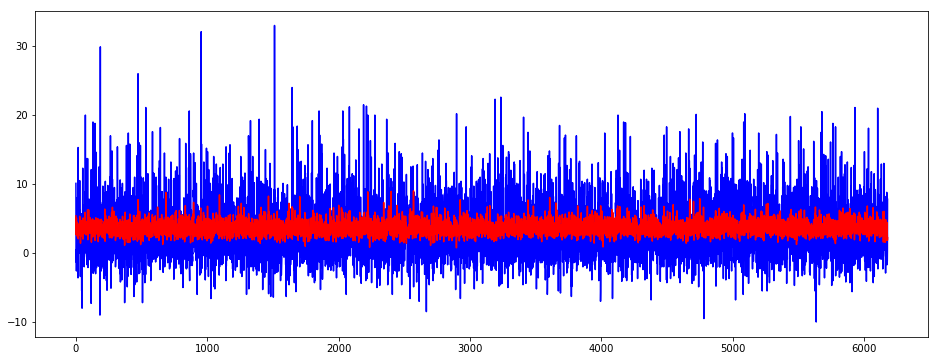

In [25]:
plt.figure(figsize=(16,6))
plt.plot(range(scores.shape[0]), scores, color='blue')
plt.plot(range(scores_pred.shape[0]), scores_pred, color='red')

No gráfico acima, cada ponto no eixo x representa um jogador. No eixo y, temos em azul a pontuação real do jogador e, em vermelho, a pontuação predita pela rede.

Vamos agora salvar o nosso modelo para uso futuro.

In [26]:
pkl.dump(reg, open('../../src/python/models/nn1.pkl', 'wb'), -1)

# 4. Predições

Essa seção é responsável por carregar o nosso modelo treinado e predizer os jogadores para uma próxima rodada do campeonado Brasileiro.

In [42]:
df_test = pd.read_csv('../../data/dados_agregados_limpos.csv')
df_test = df_test[df_test.ano == 2017]
reg = pkl.load(open('../../src/python/models/nn1.pkl', 'rb'))

In [44]:
def to_samples(df):
    df_samples = df[cols_info+cols_of_interest].copy()
    df_samples['ClubeID'] = df_samples['ClubeID'].map(dict_teams(to_int=True)) 
    df_samples['Posicao'] = df_samples['Posicao'].map(dict_positions(to_int=True))
    df_samples['variable'] = df_samples['variable'].map({'home.team':1, 'away.team':2})
    df_samples.reset_index(drop=True, inplace=True)
    return df_samples

In [45]:
def predict_best_players(df_samples, reg, n_players=11):
    samples = df_samples[df_samples.columns.difference(['AtletaID', 'Rodada', 'ano'])].values.astype(np.float64)
    
    pred = reg.predict(samples)
    best_indexes = pred.argsort()[-n_players:]
    return df_samples.iloc[best_indexes]

def predict_best_players_by_position(df_samples, reg, n_gol=5, n_zag=5, n_lat=5, n_mei=5, n_atk=5):
    df_result = pd.DataFrame(columns=df_samples.columns)
    for n_players, pos in zip([n_gol, n_zag, n_lat, n_mei, n_atk], range(1,6)):
        samples = df_samples[df_samples['Posicao'] == pos]
        df_pos = predict_best_players(samples, reg, n_players)
        df_result = df_result.append(df_pos)

    return df_result

In [46]:
df_rodada = df_test[(df_test['Rodada'] == (ROUND_TO_PREDICT-1)) & (df_test['Status'] == "Provável")]
df_samples = to_samples(df_rodada)
print(df_samples.shape)

(155, 74)


In [47]:
df_players = predict_best_players(df_samples, reg, n_players=25)
df_rodada.iloc[df_players.index][['Apelido', 'Posicao', 'ClubeID']].sort_values('Posicao')

,Apelido,Posicao,ClubeID
15794,Bruno Henrique,ata,Santos
7225,Dudu,ata,Palmeiras
5214,Lucca,ata,Ponte Preta
6288,André,ata,Sport
14174,Jandrei,gol,Chapecoense
8346,Sidão,gol,São Paulo
8084,Martín Silva,gol,Vasco
16062,Jean,gol,Bahia
9962,Gatito Fernández,gol,Botafogo
5668,Vanderlei,gol,Santos


In [48]:
df_players = predict_best_players_by_position(df_samples, reg, n_gol=5, n_zag=5, n_lat=5, n_mei=5, n_atk=5)
df_rodada.iloc[df_players.index][['Apelido', 'Posicao', 'ClubeID']]

,Apelido,Posicao,ClubeID
16062,Jean,gol,Bahia
8084,Martín Silva,gol,Vasco
8346,Sidão,gol,São Paulo
9962,Gatito Fernández,gol,Botafogo
5668,Vanderlei,gol,Santos
7293,Leonardo Silva,zag,Atlético-MG
4597,Anderson Martins,zag,Vasco
15030,Balbuena,zag,Corinthians
15479,Igor Rabello,zag,Botafogo
9675,Rodrigo Caio,zag,São Paulo
